In [11]:
%matplotlib inline
# uncomment the next line to enable interactive plots.
#%matplotlib qt5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3 as sql

In [12]:
# uncomment this block if you have an Intel machine.
# (It is recommended for better performance, but not mandatory.)
#from sklearnex import patch_sklearn
#patch_sklearn()

In [13]:
# Take only n elements from the database (None for no limit.)
n = None
# Random seed for all random things.
random_state = 0

In [14]:
conn = sql.connect('deltas.db')
query = 'SELECT delta1, delta2, period from terminals'

if n:
    query += f' limit {n};'
df = pd.read_sql_query(query, conn)

In [15]:
df.describe()

delta1        delta2
count  59935.000000  59935.000000
mean      38.011946    107.710787
std       11.678868     37.344543
min       14.000000     36.000000
25%       30.000000     81.000000
50%       35.000000     99.000000
75%       44.000000    125.000000
max      154.000000    490.000000

Text(0, 0.5, '$\\delta_2$')

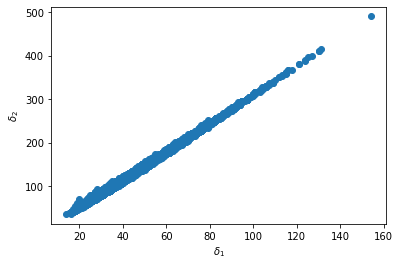

In [16]:
fig, ax = plt.subplots()
ax.scatter(df['delta1'], df['delta2'])
ax.set_xlabel(r'$\delta_1$')
ax.set_ylabel(r'$\delta_2$')


In [17]:
# Choose a starting index for the period sequences
# (we might have to throw away a few terms to get rid
# of the occasional zero period that would be mapped to
# infinity under the log map.)
n_start = 15

def split_cols(x):
    ''' Transforms period sequences from text to tables. '''
    terms = x.rstrip(']').split(',')
    # if there are more than one zeros in the period sequence,
    # we are going to remove it from the database, so that we
    # can later have a cleaner Principal Components Decomposition.
    if sum([t == '0' for t in terms]) > 1:
        return np.array([np.nan for _ in terms[n_start:]])
    return np.array([np.log(float(t)) for t in terms[n_start:]])

# terms of the period sequence
n_terms = len(df['period'][0].split(','))
ps_cols = [f'ps{i}' for i in range(n_start, n_terms)]


vec_split_cols = np.vectorize(split_cols)
data = np.array([vec_split_cols(x) for x in df['period'].values])

df_comp = pd.DataFrame(data,
                       columns=ps_cols,
                       index=df.index)

# drop NaNs or Infs that could have appeared for the Fano indexes > 1.
mask = np.any(np.isnan(df_comp) | np.isinf(df_comp), axis=1)
print(mask.shape)
# replace with nan values where ~mask is False
df_comp.where(~mask, inplace=True)
df_comp.dropna(inplace=True)

print(df_comp.shape)
df_comp.describe()

(59935,)
(58749, 16)


ps15          ps16          ps17          ps18          ps19  \
count  58749.000000  58749.000000  58749.000000  58749.000000  58749.000000   
mean      31.380414     33.813137     36.249319     38.695329     41.144042   
std        3.399623      3.629855      3.863973      4.094510      4.328641   
min       18.896149     20.550213     21.740025     23.587281     25.119686   
25%       29.048017     31.321101     33.597994     35.882433     38.172862   
50%       31.489960     33.929585     36.374428     38.827803     41.284771   
75%       33.786438     36.381564     38.984408     41.592734     44.209659   
max       43.701891     46.977985     50.261425     53.551413     56.847252   

               ps20          ps21          ps22          ps23          ps24  \
count  58749.000000  58749.000000  58749.000000  58749.000000  58749.000000   
mean      43.600659     46.059705     48.524928     50.992461     53.465006   
std        4.559560      4.793207      5.024759      5.258032      5.489819   
min       26.726827     28.513122     29.883889     31.666604     33.254496   
25%       40.469880     42.769108     45.074732     47.382528     49.695664   
50%       43.748935     46.215553     48.688011     51.162631     53.643557   
75%       46.829479     49.454216     52.083452     54.717119     57.352971   
max       60.148360     63.454235     66.764445     70.078611     73.396405   

               ps25          ps26          ps27          ps28          ps29  \
count  58749.000000  58749.000000  58749.000000  58749.000000  58749.000000   
mean      55.939549     58.418344     60.898892     63.382997     65.868748   
std        5.723076      5.954932      6.188096      6.420165      6.653153   
min       34.764525     36.539391     38.028586     39.701531     41.364005   
25%       52.008136     54.328602     56.648198     58.973446     61.298106   
50%       56.125919     58.613121     61.099738     63.590036     66.084463   
75%       59.991405     62.633961     65.278664     67.926565     70.576944   
max       76.717536     80.041748     83.368813     86.698526     90.030705   

               ps30  
count  58749.000000  
mean      68.357480  
std        6.885380  
min       42.901930  
25%       63.627122  
50%       68.580760  
75%       73.230778  
max       93.365186

In [18]:
# Rescale all period components so that they have zero mean
# and unit variance (StandardScaler), or so that they lie in
# the unit interval (MinMaxScaler).
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#sc = StandardScaler()
sc = MinMaxScaler()
df_comp[ps_cols] = sc.fit_transform(df_comp[ps_cols])

# It could also be useful to rescale the delta vector for later.
col_deltas = ['rdelta1', 'rdelta2']  # rescaled deltas, components 1 and 2.
df_deltas = pd.DataFrame(index=df.index)
df_deltas[col_deltas] = sc.fit_transform(df[['delta1', 'delta2']])

# inner join of the two dataframes: only keep the common rows.
df = df.join(df_comp, how='inner')
df = df.join(df_deltas, how='inner')
# we don't need df_comp and df_deltas anymore
del df_comp
del df_deltas
df.describe()

delta1        delta2          ps15          ps16          ps17  \
count  58749.000000  58749.000000  58749.000000  58749.000000  58749.000000   
mean      37.565133    106.236327      0.503281      0.501856      0.508716   
std       11.116976     35.437149      0.137050      0.137350      0.135476   
min       14.000000     36.000000      0.000000      0.000000      0.000000   
25%       30.000000     81.000000      0.409255      0.407559      0.415757   
50%       35.000000     99.000000      0.507697      0.506262      0.513103   
75%       43.000000    123.000000      0.600276      0.599042      0.604612   
max      130.000000    410.000000      1.000000      1.000000      1.000000   

               ps18          ps19          ps20          ps21          ps22  \
count  58749.000000  58749.000000  58749.000000  58749.000000  58749.000000   
mean       0.504204      0.505061      0.504879      0.502176      0.505444   
std        0.136647      0.136432      0.136426      0.137180      0.136244   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.410329      0.411414      0.411204      0.408000      0.411893   
50%        0.508626      0.509497      0.509316      0.506636      0.509865   
75%        0.600900      0.601684      0.601488      0.599325      0.601931   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               ps23          ps24          ps25          ps26          ps27  \
count  58749.000000  58749.000000  58749.000000  58749.000000  58749.000000   
mean       0.503120      0.503477      0.504732      0.502937      0.504415   
std        0.136885      0.136760      0.136416      0.136888      0.136481   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.409141      0.409576      0.411022      0.408925      0.410664   
50%        0.507550      0.507925      0.509174      0.507415      0.508845   
75%        0.600086      0.600332      0.601313      0.599843      0.601013   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               ps28          ps29          ps30       rdelta1       rdelta2  
count  58749.000000  58749.000000  58749.000000  58749.000000  58749.000000  
mean       0.503893      0.503522      0.504437      0.168322      0.154706  
std        0.136608      0.136709      0.136443      0.079407      0.078055  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.410067      0.409605      0.410699      0.114286      0.099119  
50%        0.508299      0.507954      0.508862      0.150000      0.138767  
75%        0.600571      0.600265      0.601009      0.207143      0.191630  
max        1.000000      1.000000      1.000000      0.828571      0.823789

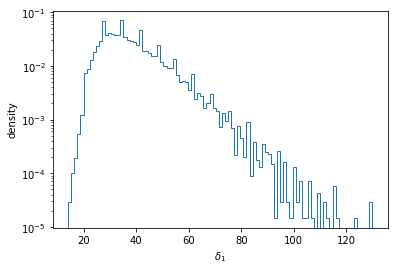

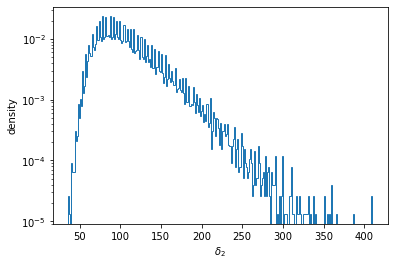

In [19]:
# Let's inspect the distribution density of the delta vector components.
fig, ax = plt.subplots()
ax.hist(df['delta1'],
        histtype='step',
        bins=df['delta1'].nunique(),
        density=True,
        log=True)
ax.set_xlabel(r'$\delta_1$')
ax.set_ylabel('density')

fig, ax = plt.subplots()
ax.hist(df['delta2'],
        histtype='step',
        bins=df['delta2'].nunique(),
        density=True,
        log=True)
ax.set_xlabel(r'$\delta_2$')
ax.set_ylabel('density')
plt.show()

We do a Principal Component Analysis on the period sequence data.

Text(0, 0.5, 'explained variance ratio')

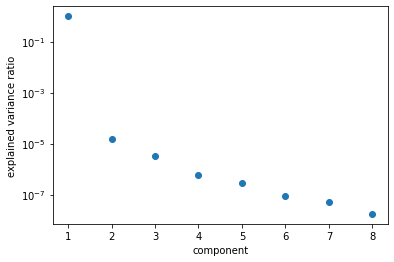

In [20]:
from sklearn.decomposition import PCA
pca = PCA(random_state=random_state)
pca.fit(df[ps_cols])

# Threshold: minimal contribution to the variance if we
# want to keep a principal component.
thresh = 1.e-8

fig, ax = plt.subplots()
mask = pca.explained_variance_ratio_ > thresh
ax.semilogy(range(1, sum(mask) + 1),
            pca.explained_variance_ratio_[mask],
           'o')
ax.set_xlabel('component')
ax.set_ylabel('explained variance ratio')

Let's have a look at the components.

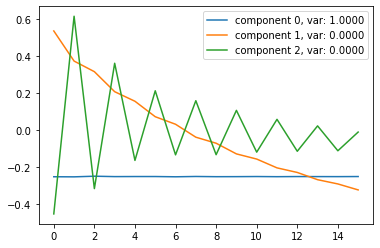

In [21]:
# Keep n_components
n_components = 3

fig, ax = plt.subplots()
for i in range(n_components):
    var = pca.explained_variance_ratio_[i]
    ax.plot(pca.components_[i, :], label=f'component {i}, var: {var:.4f}')
ax.legend(loc='best')

Let's see what the period sequences look like when we project them on the principal components.

In [22]:
from itertools import combinations

ps_mapped = pca.transform(df[ps_cols])
# rescale after mapping to the principal component space
ps_mapped = sc.fit_transform(ps_mapped[:, :n_components])

pca_cols = [f'X{i}' for i in range(1, n_components + 1)]
df_mapped = pd.DataFrame(ps_mapped,
                         columns=pca_cols,
                         index=df.index)

df = df.join(df_mapped, how='inner')

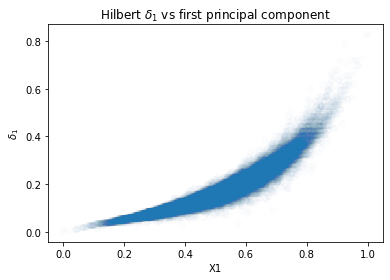

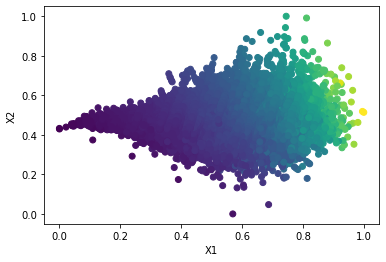

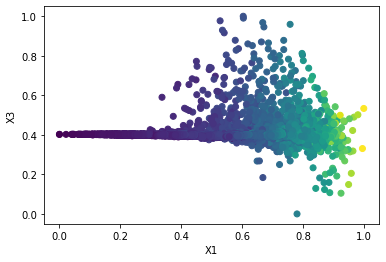

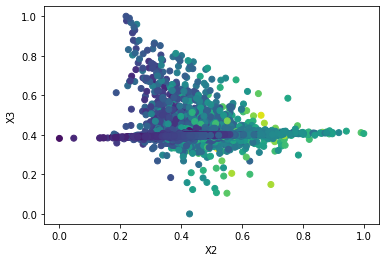

In [23]:
fig, ax = plt.subplots()
ax.scatter(df['X1'], df['rdelta1'], alpha=0.01)
ax.set_xlabel('X1')
ax.set_ylabel(r'$\delta_1$')
ax.set_title(r'Hilbert $\delta_1$ vs first principal component')

# column data used for coloring the scatter plot.
col_color = 'delta1'

for i, j in combinations(pca_cols, 2):
    fig, ax = plt.subplots()
    ax.scatter(df[i],
               df[j],
               c=df[col_color])
    ax.set_xlabel(i)
    ax.set_ylabel(j)

We attempt a linear regression for the components of the delta vector.

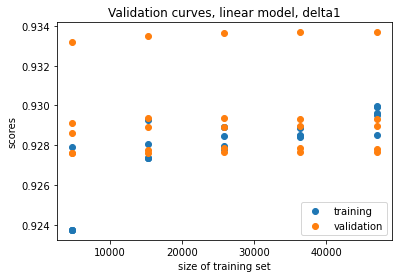

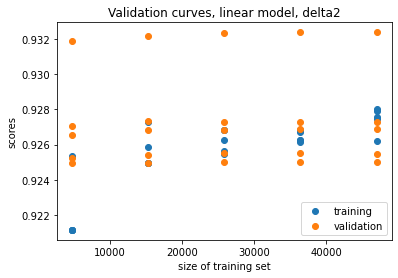

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

def plot_validation_curves(X, y, model, model_name, cv=5):
    '''
    Fits a statistical model to the data (X, y), and plots the training/
    validation curves for several sizes of the training dataset (using
    cross-validation).
    '''
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, cv=cv,
        scoring='explained_variance')

    fig, ax = plt.subplots()
    for i, n in enumerate(train_sizes):
        if i == 0:
            labelt, labelv = 'training', 'validation'
        else:
            labelt, labelv = None, None
        ax.scatter([n for _ in train_scores[i]], train_scores[i, :], c='C0', label=labelt)
        ax.scatter([n for _ in valid_scores[i]], valid_scores[i, :], c='C1', label=labelv)
    ax.legend(loc='best')
    ax.set_xlabel('size of training set')
    ax.set_ylabel('scores')
    ax.set_title(f'Validation curves, {model_name}, delta{delta}')
    plt.show()


indices = np.arange(df.shape[0])
rng = np.random.default_rng(random_state)
rng.shuffle(indices)
# Full data for cross-validation
X = df[pca_cols].iloc[indices]
y = [df['rdelta1'].iloc[indices],
     df['rdelta2'].iloc[indices]]
    
    
for delta in (1, 2):
    # Target
    plot_validation_curves(X, y[delta - 1], LinearRegression(), 'linear model')


Notice how the validation curve for the linear model is not getting any better if we consider a training set with size > ~15000.

In [25]:
# Size of the training set
n_train = 15_000


# Training set
X_train = df[pca_cols].iloc[indices[:n_train]]
y_train = [df['rdelta1'].iloc[indices[:n_train]],
           df['rdelta2'].iloc[indices[:n_train]]]
# Test set
X_test = df[pca_cols].iloc[indices[n_train:]]
y_test = [df['rdelta1'].iloc[indices[n_train:]],
          df['rdelta2'].iloc[indices[n_train:]]]

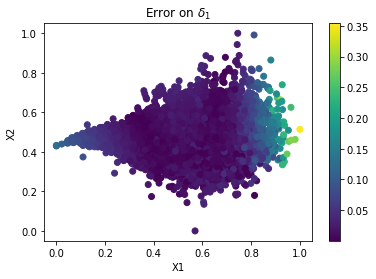

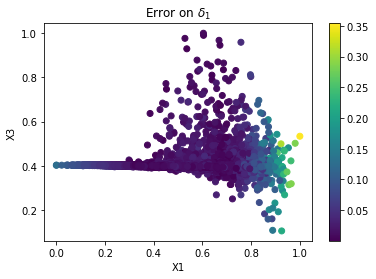

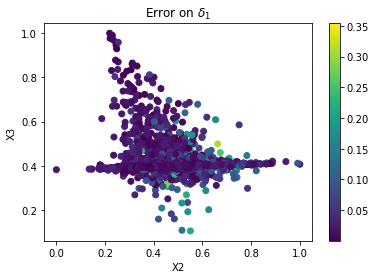

Prediction accuracy on delta2.


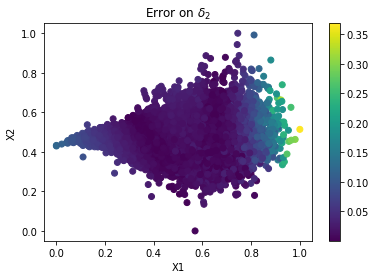

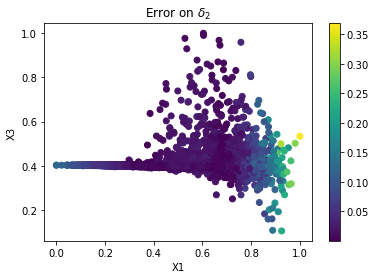

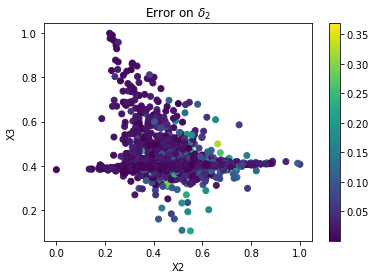

In [26]:
# column data used for coloring the scatter plot.
col_color = 'rdelta1'
# if True, plots the prediction error, otherwise makes a
# side-by-side plot of the data and the predictions.
plot_error = True

lin_model = LinearRegression()
lin_model.fit(X_train, y_train[0])
predictions = [lin_model.predict(X_test)]

lin_model.fit(X_train, y_train[1])
predictions.append(lin_model.predict(X_test))


def compare_scatter(X, data, pred, title, plot_error=False):
    '''
    Compares data with pred as a scatter plot.
    If plot_error is False, plot data and pred side by side.
    Otherwise, plots the l2 norm of the difference between
    data and pred.
    '''
    if plot_error:
        for i, j in combinations(pca_cols, 2):
            fig, ax = plt.subplots()
            c = np.sqrt(np.square(data - pred))
            s = ax.scatter(X[i], X[j], c=c)
            ax.set_xlabel(i)
            ax.set_ylabel(j)
            ax.set_title(title)
            fig.colorbar(s)
    else:
        for i, j in combinations(pca_cols, 2):
            fig, ax = plt.subplots(1, 2)
            # data
            ax[0].scatter(X[i], X[j], c=data)
            ax[0].set_xlabel(i)
            ax[0].set_ylabel(j)
            ax[0].set_title('data')
            # linear predictor
            ax[1].scatter(X[i], X[j], c=pred)
            ax[1].set_xlabel(i)
            ax[1].set_title('prediction')
    plt.show()


compare_scatter(X_test,
                y_test[0],
                predictions[0],
                r'Error on $\delta_1$',
                plot_error=plot_error)

print("Prediction accuracy on delta2.")

compare_scatter(X_test,
                y_test[1],
                predictions[1],
                r'Error on $\delta_2$',
                plot_error=plot_error)

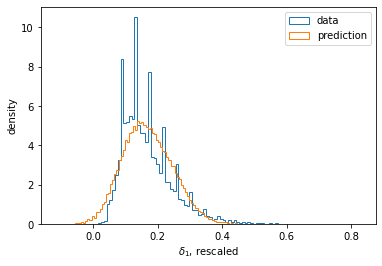

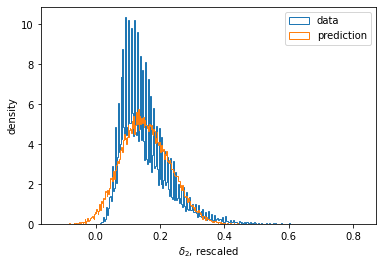

Density plots in log scale:


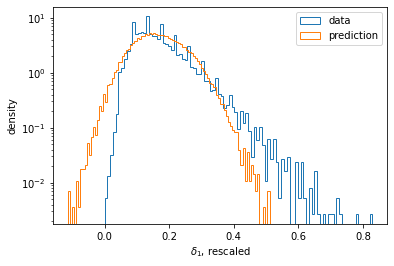

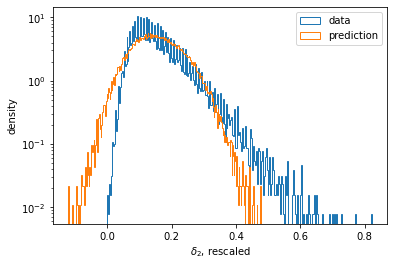

In [27]:
## Density comparison

def compare_density(data, pred, xlabel, log_scale=False):
    '''
    Compares the distribution density of data and pred.
    If log_scale is True, the y-axis is in log scale.
    '''
    fig, ax = plt.subplots()
    bins = len(np.unique(data))
    ax.hist(data,
            histtype='step',
            bins=bins,
            density=True,
            log=log_scale,
            label='data')
    ax.hist(pred,
            histtype='step',
            bins=bins,
            density=True,
            log=log_scale,
            label='prediction')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('density')
    ax.legend(loc='best')
    plt.show()
    

# We plot the density both in log and in linear scale.
for log_scale in (False, True):
    if log_scale:
        print("Density plots in log scale:")
    compare_density(y_test[0],
                    predictions[0],
                    r'$\delta_1$, rescaled',
                    log_scale=log_scale)
    compare_density(y_test[1],
                    predictions[1],
                    r'$\delta_2$, rescaled',
                    log_scale=log_scale)

    # Let's inspect the distribution density of the delta vector components.
    

Notice how the linear regressor fails to limit the range of its predictions to non-negative numbers.
We can try to constrain our statistical model to generate predictions in the interval $[0,1]$ by using a support vector regressor instead of a linear model.

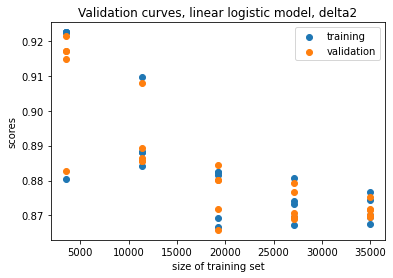

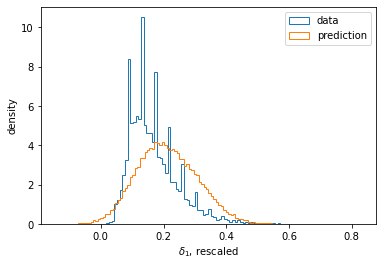

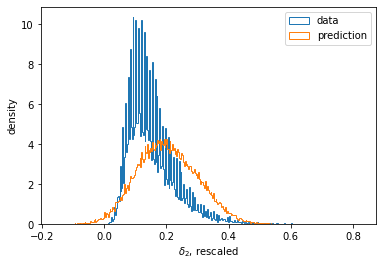

Density plots in log scale:


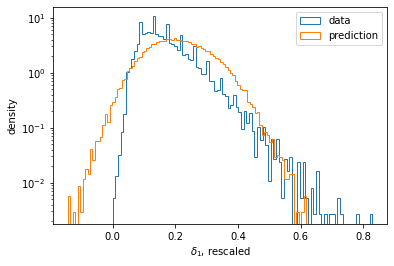

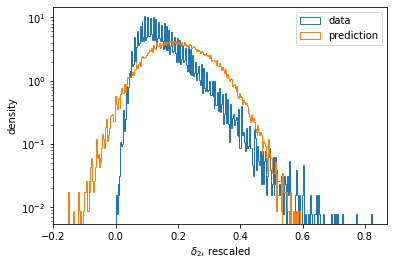

In [28]:
from sklearn.svm import SVR



for delta in (1, 2):
    # Target
    plot_validation_curves(X_test,
                           y_test[delta - 1],
                           SVR(kernel='linear'),
                           'linear logistic model')


svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train[0])
svm_predictions = [svm_model.predict(X_test)]
svm_model.fit(X_train, y_train[1])
svm_predictions.append(svm_model.predict(X_test))


for log_scale in (False, True):
    if log_scale:
        print("Density plots in log scale:")
    compare_density(y_test[0],
                    svm_predictions[0],
                    r'$\delta_1$, rescaled',
                    log_scale=log_scale)
    compare_density(y_test[1],
                    svm_predictions[1],
                    r'$\delta_2$, rescaled',
                    log_scale=log_scale)

The density distribution for the linear support vector machine is not very satisfactory. We start by trying with a nonlinear kernel.

linear kernel


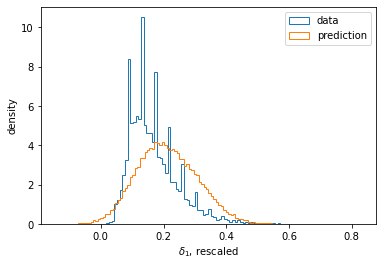

poly kernel


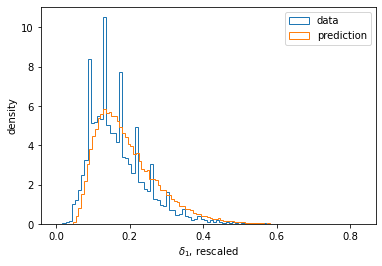

rbf kernel


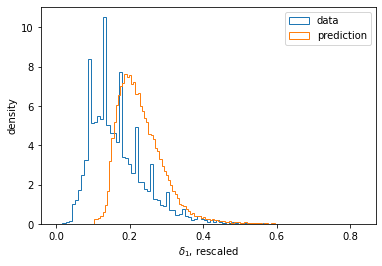

sigmoid kernel


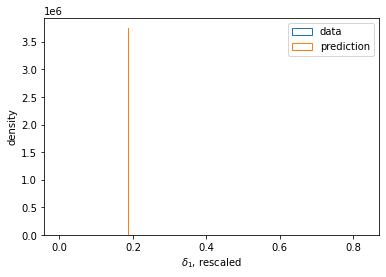

In [29]:
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    print(f'{k} kernel')
    svm_model = SVR(kernel=k)
    svm_model.fit(X_train, y_train[0])
    svm_predictions = svm_model.predict(X_test)
    compare_density(y_test[0],
                    svm_predictions,
                    r'$\delta_1$, rescaled',
                    log_scale=False)

The regressor with polynomial kernel seems to be the best in its class. However, we prefer using a radial basis function (RBF) kernel because of its simplicity (it needs only one parameter, as opposed to the two parameters required by the other kernels.
The parameters that we will use are:
- $C$, the strength of the penalisation term for misclassified points.
- $\gamma$, the coefficient in the kernel function $K(x,y) = \exp(-\gamma \|x - y\|^2)$.

As a side note, it could be interesting to try to understand why the sigmoid kernel performs so poorly.

In [30]:
from sklearn.model_selection import GridSearchCV

# Number of subdivisions for the grid search cross-validation.
n_grid_search = 2

params = {'C': np.logspace(-4, 0, num=n_grid_search),
          'gamma': np.logspace(-3, 1, num=n_grid_search)}

# If you have enough memory, you could increase cache_size (measured in Mb) for improved performance.
svm_model = SVR(kernel='rbf', cache_size=4000)
clf = GridSearchCV(svm_model, params)
clf.fit(X, y[0])
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_gamma',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

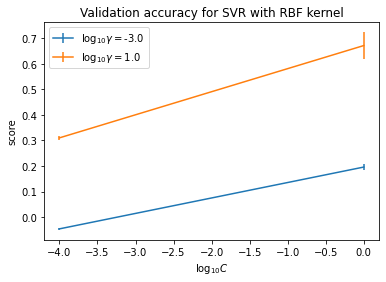

In [31]:
fig, ax = plt.subplots()
Cs = params['C']
for g in params['gamma']:
    mask = clf.cv_results_['param_gamma'] == g
    mean_test_score = clf.cv_results_['mean_test_score'][mask]
    std_test_score = clf.cv_results_['std_test_score'][mask]


    ax.errorbar(np.log10(Cs), mean_test_score, yerr=std_test_score, label=r'$\log_{10}\gamma = $' + f'{np.log10(g):.4}')
    ax.set_xlabel(r'$\log_{10} C$')
    ax.set_ylabel('score')
    ax.set_title('Validation accuracy for SVR with RBF kernel')
    ax.legend(loc='best')

An RBF kernel with $\gamma=10^{0.5556} = 3.6$ and $C=1$ seems to be a good compromise between predictor complexity and validation accuracy. We take $C=1$ also because it is the recommended value by the sklearn documentation.

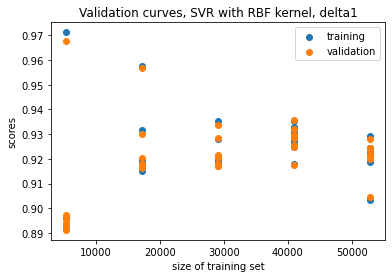

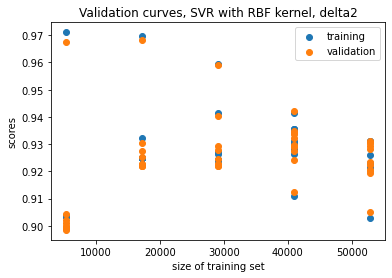

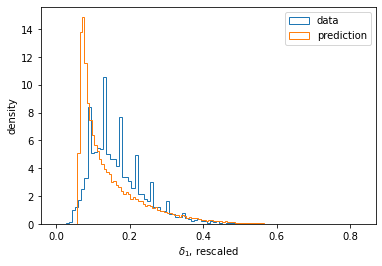

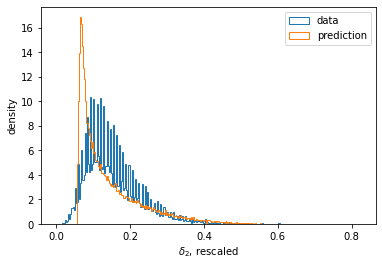

Density plots in log scale:


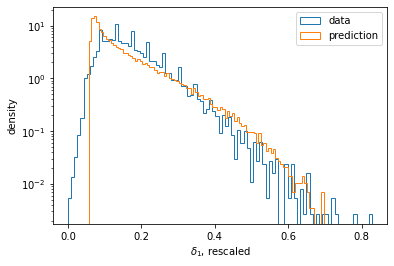

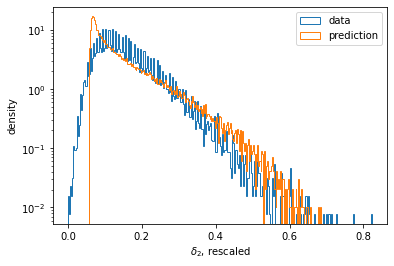

In [32]:
svm_model = SVR(kernel='rbf',
                C=1.,
                gamma=3.6,
                cache_size=4000)


for delta in (1, 2):
    # Target
    plot_validation_curves(X, y[delta - 1], svm_model, 'SVR with RBF kernel', cv=10)


svm_model.fit(X_train, y_train[0])
svm_predictions = [svm_model.predict(X_test)]
svm_model.fit(X_train, y_train[1])
svm_predictions.append(svm_model.predict(X_test))


for log_scale in (False, True):
    if log_scale:
        print("Density plots in log scale:")
    compare_density(y_test[0],
                    svm_predictions[0],
                    r'$\delta_1$, rescaled',
                    log_scale=log_scale)
    compare_density(y_test[1],
                    svm_predictions[1],
                    r'$\delta_2$, rescaled',
                    log_scale=log_scale)

Interestingly, it seems quite clear that the best parameters for training the SVR are obtained with ~4000 training elements, regardless of the training sample (look at the low variance in the cross-validation results).

Error estimates on delta1
[0.89939535 0.90970957 0.90750334 0.91695614 0.89482154 0.91878179
 0.91654038 0.9457438  0.911021   0.9079334 ]
Error estimates on delta2
[0.90243034 0.89829796 0.88867905 0.90863    0.92259608 0.90967344
 0.9069029  0.89506957 0.89698453 0.898854  ]


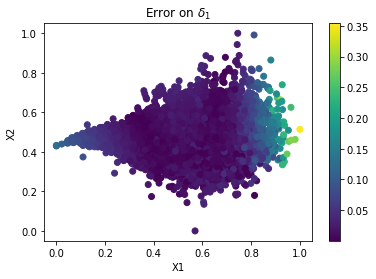

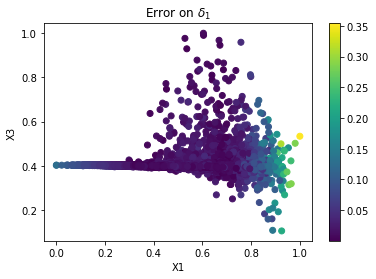

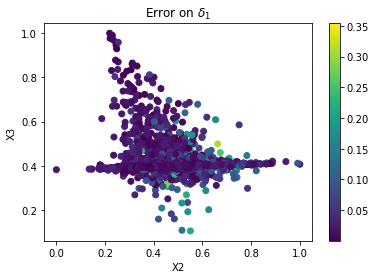

Prediction accuracy on delta2.


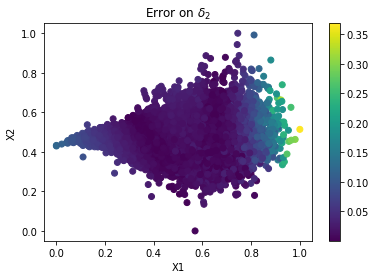

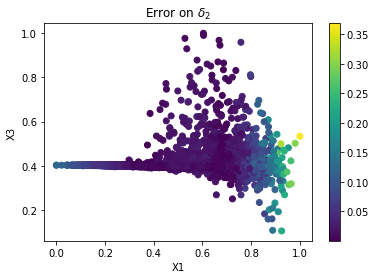

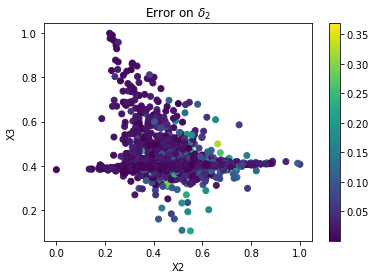

In [33]:
# if True, plots the prediction error, otherwise makes a
# side-by-side plot of the data and the predictions.
plot_error = True


# Error estimates on delta1.
from sklearn.model_selection import cross_val_score
# For SVR, the error estimate is the coefficient of determination R^2 of the regression.
print('Error estimates on delta1')
svm_model.fit(X_train, y_train[0])
print(cross_val_score(svm_model, X_test, y_test[0], cv=10))


# Error estimates on delta2
svm_model.fit(X_train, y_train[1])
print('Error estimates on delta2')
print(cross_val_score(svm_model, X_test, y_test[1], cv=10))

compare_scatter(X_test,
                y_test[0],
                predictions[0],
                r'Error on $\delta_1$',
                plot_error=plot_error)

print("Prediction accuracy on delta2.")

compare_scatter(X_test,
                y_test[1],
                predictions[1],
                r'Error on $\delta_2$',
                plot_error=plot_error)

We try again with the polynomial kernel.

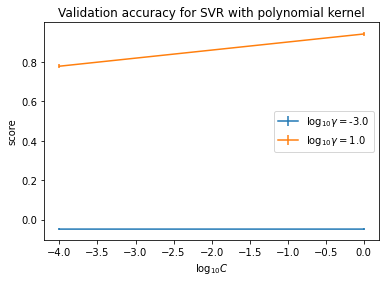

In [34]:
params = {'C': np.logspace(-4, 0, num=n_grid_search),
          'gamma': np.logspace(-3, 1, num=n_grid_search)}

# If you have enough memory, you could increase cache_size (measured in Mb) for improved performance.
svm_model = SVR(kernel='poly', cache_size=4000)
clf = GridSearchCV(svm_model, params)
clf.fit(X, y[0])

fig, ax = plt.subplots()
Cs = params['C']
for g in params['gamma']:
    mask = clf.cv_results_['param_gamma'] == g
    mean_test_score = clf.cv_results_['mean_test_score'][mask]
    std_test_score = clf.cv_results_['std_test_score'][mask]


    ax.errorbar(np.log10(Cs), mean_test_score, yerr=std_test_score, label=r'$\log_{10}\gamma = $' + f'{np.log10(g):.4}')
    ax.set_xlabel(r'$\log_{10} C$')
    ax.set_ylabel('score')
    ax.set_title('Validation accuracy for SVR with polynomial kernel')
    ax.legend(loc='best')

As a last model, we use a boosting method with a linear regressor as its base predictor.

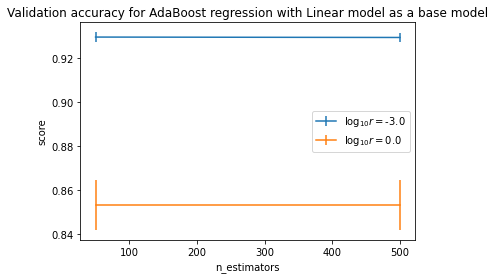

In [35]:
from sklearn.ensemble import AdaBoostRegressor

params = {'n_estimators': np.linspace(50, 500, num=n_grid_search, dtype=np.int32),
          'learning_rate': np.logspace(-3, 0, num=n_grid_search)}

# If you have enough memory, you could increase cache_size (measured in Mb) for improved performance.
boost_model = AdaBoostRegressor(base_estimator=LinearRegression(),
                                random_state=random_state)

clf = GridSearchCV(boost_model, params)
clf.fit(X, y[0])


# Plot of the cross-validation curves.
fig, ax = plt.subplots()
NEs = params['n_estimators']
for r in params['learning_rate']:
    mask = clf.cv_results_['param_learning_rate'] == r
    mean_test_score = clf.cv_results_['mean_test_score'][mask]
    std_test_score = clf.cv_results_['std_test_score'][mask]


    ax.errorbar(NEs,
                mean_test_score,
                yerr=std_test_score,
                label=r'$\log_{10}r = $' + f'{np.log10(r):.4}')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('score')
    ax.set_title('Validation accuracy for AdaBoost regression with Linear model as a base model')
    ax.legend(loc='best')

cross validation scores on delta 1:
[0.91078347 0.90484049 0.90789975 0.9117279  0.90479877 0.91365366
 0.91030886 0.91142598 0.91631651 0.91453418]
cross validation scores on delta 2:
[0.90691345 0.90197558 0.90242131 0.90542109 0.90187837 0.90815499
 0.9038232  0.90689774 0.91137704 0.91030906]


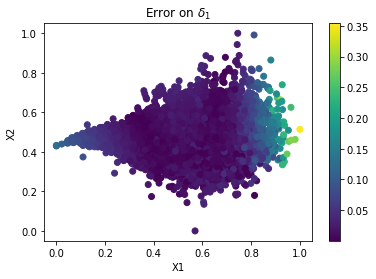

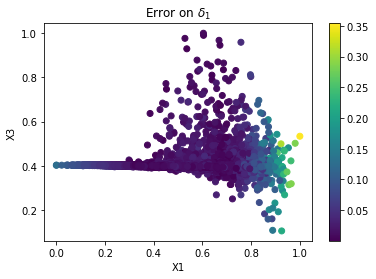

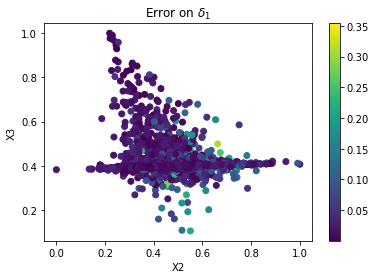

In [36]:
boost_model = AdaBoostRegressor(base_estimator=LinearRegression(),
                                n_estimators=50,
                                learning_rate=1.e-1,
                                random_state=random_state)

boost_model.fit(X_train, y_train[0])
print("cross validation scores on delta 1:")
print(cross_val_score(boost_model, X_test, y_test[0], cv=10))
boost_model.fit(X_train, y_train[1])
print("cross validation scores on delta 2:")
print(cross_val_score(boost_model, X_test, y_test[1], cv=10))

compare_scatter(X_test,
                y_test[0],
                predictions[0],
                r'Error on $\delta_1$',
                plot_error=plot_error)

We also experiment with using a SVR as a base estimator for the boosting algorithm.

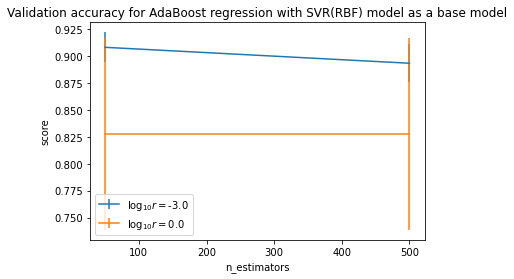

In [37]:
svm_model = SVR(kernel='rbf',
                C=1.,
                gamma=3.6,
                cache_size=4000)

boost_model = AdaBoostRegressor(base_estimator=svm_model,
                                random_state=random_state)

clf = GridSearchCV(boost_model, params)
clf.fit(X, y[0])


# Plot of the cross-validation curves.
fig, ax = plt.subplots()
NEs = params['n_estimators']
for r in params['learning_rate']:
    mask = clf.cv_results_['param_learning_rate'] == r
    mean_test_score = clf.cv_results_['mean_test_score'][mask]
    std_test_score = clf.cv_results_['std_test_score'][mask]


    ax.errorbar(NEs,
                mean_test_score,
                yerr=std_test_score,
                label=r'$\log_{10}r = $' + f'{np.log10(r):.4}')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('score')
    ax.set_title('Validation accuracy for AdaBoost regression with SVR(RBF) model as a base model')
    ax.legend(loc='best')

Note the huge error bars!

cross validation scores on delta 1:
[0.91833149 0.93183673 0.9306982  0.93941197 0.93408096 0.93370488
 0.93219579 0.93779044 0.92343739 0.92188911]
cross validation scores on delta 2:
[0.93325982 0.93073179 0.93604589 0.93879234 0.92030821 0.93381127
 0.9350012  0.91867784 0.93380765 0.92893643]


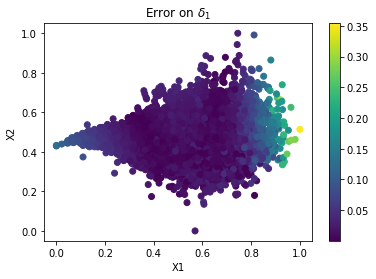

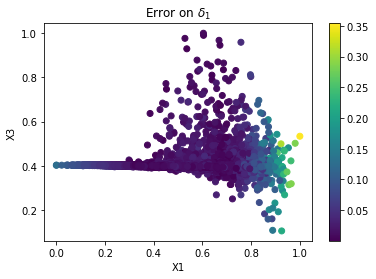

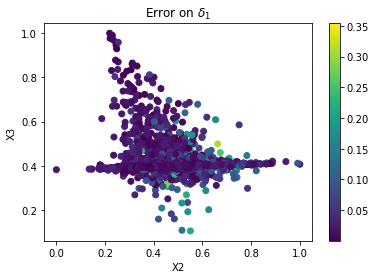

In [38]:
boost_model = AdaBoostRegressor(base_estimator=svm_model,
                                n_estimators=50,
                                learning_rate=1.e-3,
                                random_state=0)

boost_model.fit(X_train, y_train[0])
print("cross validation scores on delta 1:")
print(cross_val_score(boost_model, X_test, y_test[0], cv=10))

boost_model.fit(X_train, y_train[1])
print("cross validation scores on delta 2:")
print(cross_val_score(boost_model, X_test, y_test[1], cv=10))

compare_scatter(X_test,
                y_test[0],
                predictions[0],
                r'Error on $\delta_1$',
                plot_error=plot_error)